In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
import random

# ============ 1. 定义原料列表 ============

amine_head_list = [
    "NCCO"
]

linker_list = [
    "O=C(O)CCCCCCCBr",
    "O=C(O)CCCCCBr"
]

#linker_2_list = [
#    "CCCC[N+]#[C-]"
#]

Tail_1_list = [
    "CCCCCCCCC(O)CCCCCCCC"
]

Tail_2_list = [
    "CCCCCCCCCCCO"
]

# ============ 2. 定义两步反应 SMARTS ============

# Step 1: 只匹配末端醛(R–CH=O) + 伯胺(-NH2) => 亚胺
#   [CX3H1:1](=O)[CX4:2] 表示末端醛碳(sp2, 带1氢)连着一个sp3碳
#   [NH2:3] 表示伯胺
#imine_reaction_smarts = "[CX3H1:1](=O)[CX4:2].[NH2:3]>>[CX3H1:1](=[N:3])[CX4:2]"
#imine_reaction_smarts = "[CX3H0:1](=O)([CX4:2])([CX4:3]).[NH2:4] >> [CX3H0:1](=[N:4])([CX4:2])([CX4:3])"
#rxn_imine = AllChem.ReactionFromSmarts(imine_reaction_smarts)

# Step 2: 亚胺 + 异腈 + 羧酸 => Ugi 产物 (简化示例)
# 这里用 [C-]#[N+] 表示异腈
#ugi_reaction_smarts = "[C:1](=[N:2]).[C-:3]#[N+:4].[C:5](=[O:6])O>>[C:1]-[N+:4]-[C-:3]-[N:2]-[C:5](=[O:6])"
#rxn_ugi = AllChem.ReactionFromSmarts(ugi_reaction_smarts)



In [10]:
def process_and_save_products(product_mols, step_name):
    """
    1) 去重 & 转SMILES
    2) 打印SMILES到控制台
    3) 输出到 CSV: f"{step_name}_products.csv"
    4) 在 Notebook 中显示网格图, 并保存到 f"{step_name}_products.png"
    5) 返回去重 & sanitize 后的有效 Mols
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_mols:
        print(f"[{step_name}] 没有产物生成.")
        return []

    # 1) 去重并转成 SMILES
    unique_smiles = list(set(Chem.MolToSmiles(m, isomericSmiles=True) for m in product_mols))
    print(f"[{step_name}] 原产物数: {len(product_mols)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查
    valid_mols = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)  # RDKit 化学有效性检查
            valid_mols.append(mol)  # 通过的分子
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)

    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "SMILES"])
        for idx, mol in enumerate(valid_mols, start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) Notebook 中显示网格图
    if valid_mols:
        img_for_notebook = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img_for_notebook)

        # 7) 可选: 保存 PNG (注释可取消启用)
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols  # 返回最终有效分子


============ 开始第一步反应 ============
[step1] 原产物数: 2, 去重后: 2
[step1] 产物 SMILES 列表 (去重后):
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCCCCCBr
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCCCBr
[step1] Sanitize 检查后有效产物数: 2，非法产物数: 0
[step1] 有效产物 CSV 已保存: step1_products.csv


[15:13:46] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


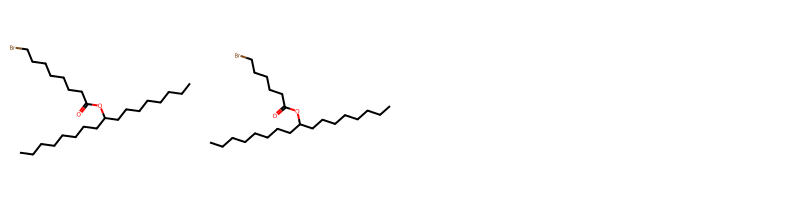

In [11]:
# ============ 第一步反应 ============
rxn1_smarts = "[C:1](=O)O.[O:2][C:3]>>[C:1](=O)O[C:3]"
rxn1 = AllChem.ReactionFromSmarts(rxn1_smarts)

print("============ 开始第一步反应 ============")
step1_products = []
for linker_smi, tail_smi in product(linker_list, Tail_1_list):  # 现在可以正确调用 product
    mol_linker = Chem.MolFromSmiles(linker_smi)
    mol_tail = Chem.MolFromSmiles(tail_smi)
    
    if not mol_linker or not mol_tail:
        print(f"无效原料组合: {linker_smi} + {tail_smi}")
        continue
    
    products = rxn1.RunReactants((mol_linker, mol_tail))
    if products:
        step1_products.extend([p[0] for p in products])

# 确保已定义 process_and_save_products 函数
valid_step1 = process_and_save_products(step1_products, "step1")

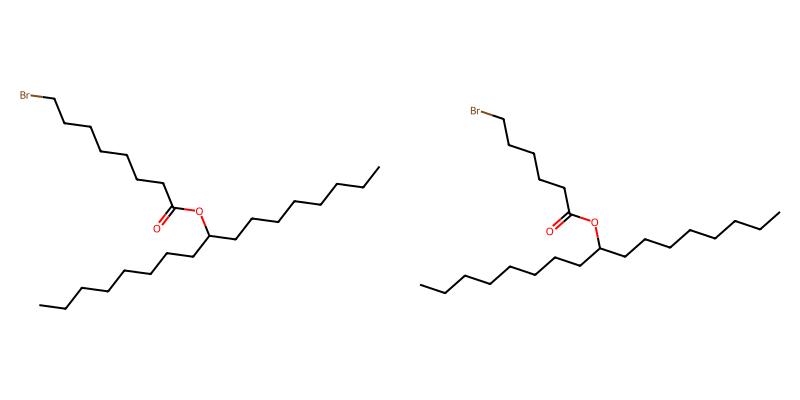

In [12]:
from rdkit.Chem import AllChem, Draw
img = Draw.MolsToGridImage(valid_step1, molsPerRow=2, subImgSize=(400, 400))
display(img)


============ 开始第二步反应 ============
[step2] 原产物数: 2, 去重后: 2
[step2] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCCOC(=O)CCCCCCCBr
   CCCCCCCCCCCOC(=O)CCCCCBr
[step2] Sanitize 检查后有效产物数: 2，非法产物数: 0
[step2] 有效产物 CSV 已保存: step2_products.csv


[15:21:23] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


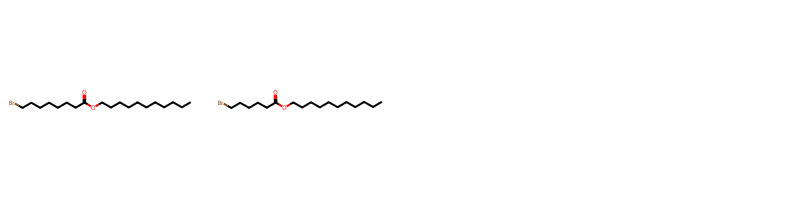

In [14]:
# ============ 第二步反应执行 ============
rxn2_smarts = "[C:1](=O)O.[O:2][C:3]>>[C:1](=O)O[C:3]"
rxn2 = AllChem.ReactionFromSmarts(rxn2_smarts)

print("\n============ 开始第二步反应 ============")
step2_products = []
for linker_smi, tail_smi in product(linker_list, Tail_2_list):
    mol_linker = Chem.MolFromSmiles(linker_smi)
    mol_tail = Chem.MolFromSmiles(tail_smi)
    
    if not mol_linker or not mol_tail:
        print(f"无效原料组合: {linker_smi} + {tail_smi}")
        continue
    
    products = rxn2.RunReactants((mol_linker, mol_tail))
    if products:
        step2_products.extend([p[0] for p in products])

# 确保已正确定义process_and_save_products函数
valid_step2 = process_and_save_products(step2_products, "step2")

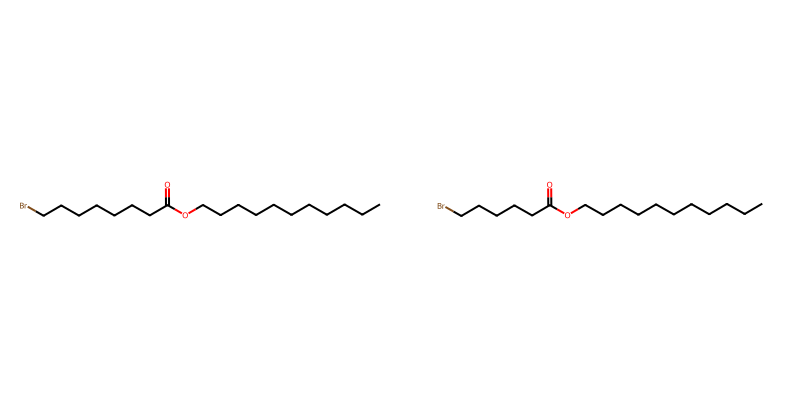

In [15]:
from rdkit.Chem import AllChem, Draw
img = Draw.MolsToGridImage(valid_step2, molsPerRow=2, subImgSize=(400, 400))
display(img)


开始第三步反应 (双溴取代缩合)
预期组合数: 4

处理组合 1:
  √ 有效产物1: CCCCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
  本组合有效产物数: 1/1

处理组合 2:
  √ 有效产物1: CCCCCCCCCCCOC(=O)CCCCCN(CCO)CCCCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
  本组合有效产物数: 1/1

处理组合 3:
  √ 有效产物1: CCCCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
  本组合有效产物数: 1/1

处理组合 4:
  √ 有效产物1: CCCCCCCCCCCOC(=O)CCCCCN(CCO)CCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
  本组合有效产物数: 1/1

[final] 原产物数: 4, 去重后: 4
[final] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCCOC(=O)CCCCCN(CCO)CCCCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
   CCCCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
   CCCCCCCCCCCOC(=O)CCCCCN(CCO)CCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
   CCCCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCCCCCCC)CCCCCCCC
[final] Sanitize 检查后有效产物数: 4，非法产物数: 0
[final] 有效产物 CSV 已保存: final_products.csv


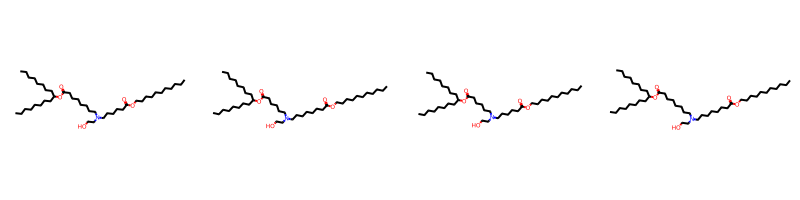

In [27]:
# ============ 第三步反应 ============
# 修正后的双溴取代反应规则
rxn3_smarts = "[NH2:1][C:2].[C:3]Br.[C:4]Br>>[N:1]([C:2])([C:3])[C:4]"
rxn3 = AllChem.ReactionFromSmarts(rxn3_smarts)

print("\n" + "="*40)
print("开始第三步反应 (双溴取代缩合)")
print("预期组合数:", len(amine_head_list)*len(valid_step1)*len(valid_step2))

# 定义验证模板
amine_pattern = Chem.MolFromSmarts("[NH2]")  # 氨基验证
bromine_pattern = Chem.MolFromSmarts("[Br]")  # 溴原子验证

final_products = []
for idx, (amine_smi, int1_mol, int2_mol) in enumerate(
    product(amine_head_list, valid_step1, valid_step2), 1
):
    print(f"\n处理组合 {idx}:")
    
    # ===== 检查点1: 验证胺结构 =====
    mol_amine = Chem.MolFromSmiles(amine_smi)
    if not mol_amine or not mol_amine.HasSubstructMatch(amine_pattern):
        print(f"  ! 无效胺原料: {amine_smi}")
        print("  失败原因: 缺少氨基(NH2)基团")
        continue
    
    # ===== 检查点2: 验证中间产物1含溴 =====
    int1_smi = Chem.MolToSmiles(int1_mol)
    if not int1_mol.HasSubstructMatch(bromine_pattern):
        print(f"  ! 中间产物1无效: {int1_smi}")
        print("  失败原因: 中间产物1缺少溴原子")
        continue
    
    # ===== 检查点3: 验证中间产物2含溴 =====
    int2_smi = Chem.MolToSmiles(int2_mol)
    if not int2_mol.HasSubstructMatch(bromine_pattern):
        print(f"  ! 中间产物2无效: {int2_smi}")
        print("  失败原因: 中间产物2缺少溴原子")
        continue
    
    # ===== 执行反应 =====
    products = rxn3.RunReactants((mol_amine, int1_mol, int2_mol))
    
    if not products:
        print(f"  × 未生成产物 (胺: {amine_smi})")
        print(f"  可能原因: 溴原子取代位点不匹配")
        continue
    
    # ===== 处理产物 =====
    valid_count = 0
    for p_idx, p_tuple in enumerate(products, 1):
        try:
            p_mol = p_tuple[0]
            Chem.SanitizeMol(p_mol)
            
            # ===== 检查点4: 验证双取代结构 =====
            if not p_mol.HasSubstructMatch(Chem.MolFromSmarts("N(C)(C)C")):
                print(f"  ! 异常产物{p_idx}: {Chem.MolToSmiles(p_mol)}")
                print("  失败原因: 未形成正确取代结构")
                continue
                
            final_products.append(p_mol)
            valid_count += 1
            print(f"  √ 有效产物{p_idx}: {Chem.MolToSmiles(p_mol)}")
            
        except Exception as e:
            print(f"  ! 非法产物{p_idx}: {Chem.MolToSmiles(p_mol)}")
            print(f"  错误详情: {str(e)}")

    print(f"  本组合有效产物数: {valid_count}/{len(products)}")

# 处理并保存最终产物
print("\n" + "="*40)
valid_final = process_and_save_products(final_products, "final")



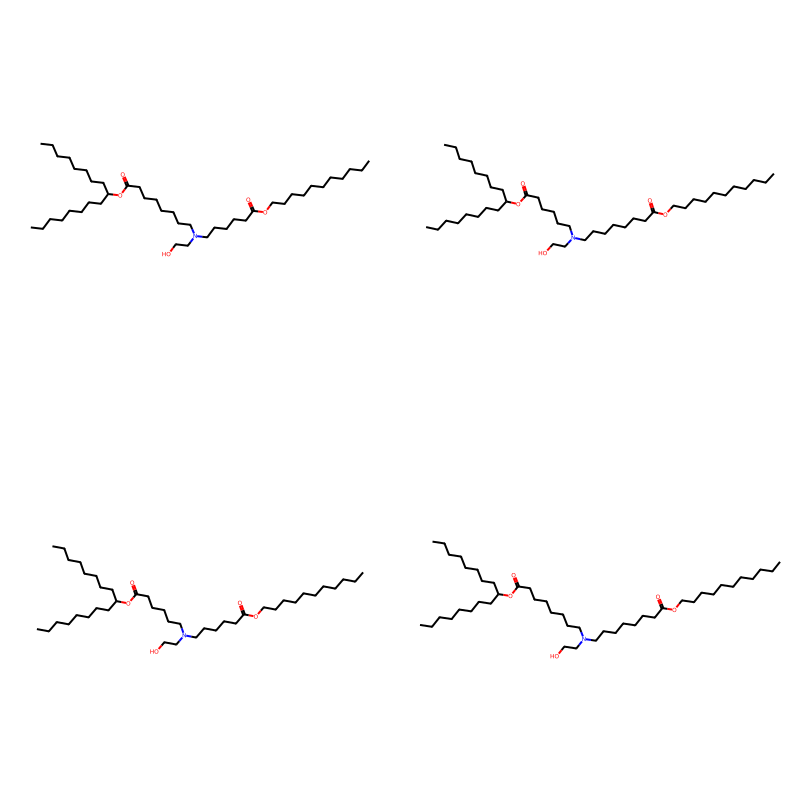

In [30]:
from rdkit.Chem import AllChem, Draw
img = Draw.MolsToGridImage(valid_final, molsPerRow=2, subImgSize=(400, 400))
display(img)